# LSTM models for multivariate Time Series forecastings

## Sommaire

- [I. Préparation des données](#present_data)

- [II. Construction de 2 models LSTM](#LSTM)
    - [II.A LSTM avec des TS non stationarisées](#LSTMA)
    - [II.B LSTM avec des TS stationarisées](#LSTMB)


In [91]:
rm(list=ls())
suppressPackageStartupMessages(require(skimr))
suppressPackageStartupMessages(require(readxl))
suppressPackageStartupMessages(require(stringr))
suppressPackageStartupMessages(require(dplyr))
suppressPackageStartupMessages(require(ggplot2))
suppressPackageStartupMessages(require(forecast))

<div id="present_data">

# I . Data preparation

In [92]:
#------------------------------------------------------
# data pre treatment (similar to univariate case)

df <- read_excel("data/data.xlsx",sheet = 3)
tmp <-df%>% filter(aire=="44_GRAND EST" & champ=="ESS")

df <-tmp[-which(!is.na(tmp$secret_stat)),]%>%select(-secret_stat)
df <- df %>% select(-champ,-type_aire,-type_naf,-aire)
df <- df[,c(TRUE,str_detect(colnames(df),"nb_etab")[-1])]
tmp <- t(df)
colnames(tmp) <- tmp[1,]
tmp <-tmp[-1,]
df <- tmp
tmp <-df%>%as.data.frame
tmp <-cbind("date"=rep(NA,nrow(tmp)),tmp)
for (i in 1:nrow(tmp)){
    tmp.format.date <- strsplit(rownames(df)[i],"nb_etab")[[1]][2]
    subsplit <-strsplit(tmp.format.date,"T")[[1]]
    year<-subsplit[1]
    trimester <- subsplit[2]
    month <-switch(trimester,
        "1"="01",
        "2"="04",
        "3"="07",
        "4"="10"
    )
    tmp[i,1] <- paste(year,month,"01",sep="-")
}
tmp$date <-as.Date(tmp$date)
rownames(tmp) <- NULL

df.indexes <-which(tmp$date < as.Date("2020-01-01"))
train.indexes<- which(tmp$date < as.Date("2018-01-01") )
test.indexes <-which(tmp$date>= as.Date("2018-01-01") & tmp$date <as.Date("2020-01-01") )
tmp <-tmp %>%select(-date)%>% mutate_all(as.numeric)
#----------------------------
# Eliminate total serie
tmp <- tmp[,-ncol(tmp)]
df.ts <- ts(tmp[df.indexes,],start=c(2010,1),frequency=4)# S'arrete à 2019 Q4
train.ts <-ts(tmp[train.indexes,],start=c(2010,1),frequency = 4)# S'arrete à 2017 Q4
test.ts <-ts(tmp[test.indexes,],start = c(2018,1),frequency = 4)# Commence a 2018 Q1 --> 2019 Q4
global.ts <- ts(tmp,start=c(2010,1),frequency=4)# Commence a 2010 Q1 --> 2021 Q2
covid.ts <- ts(tmp[(df.indexes[length(df.indexes)]+1):nrow(tmp),],start=c(2020,1),frequency = 4)# Commence a 2020 Q1 --> 2021 Q2

In [93]:
require(tensorflow)
require(keras)

In [94]:
lab.to.num <-cbind("lab"=colnames(df.ts),"num"=1:length(colnames(df.ts))) %>%as.data.frame
lab.to.num$num <- as.numeric(lab.to.num$num)
colnames(df.ts) <-lab.to.num$num

In [95]:
df.train <-df.ts %>% as.data.frame

In [96]:
#-----------------------------
# Scaled the train sample and get the sample factor parmas: mean + sd
scaled_train <- scale(df.train)
scale_factor <-list("center"=attr(scaled_train,"scaled:center"),"sd"=attr(scaled_train,"scaled:scale"))

In [97]:
#----------------
# We d like to do a 6 Quarter forecast,
# We need to base each prediction on 6 points
prediction <- 6
lag <- prediction

In [98]:

x_train_data <-t(sapply(
    1:(dim(scaled_train)[1]-lag-prediction +1),
    function(x){scaled_train[x:(x+lag-1),1]}
))

for(i in 2:ncol(scaled_train)){
    new <-t(sapply(
        1:(dim(scaled_train)[1]-lag-prediction +1),
        function(x){scaled_train[x:(x+lag-1),i]}
    ))
    x_train_data <-cbind(x_train_data,new)
    
}

In [99]:
cat("Shape de  X_train :",x_train_data%>% dim)

Shape de  X_train : 29 156

In [100]:
x_train_arr <- array(
    data=as.numeric(unlist(x_train_data)),
    dim=c(
        nrow(x_train_data),
        ncol(x_train_data),
        1
        )

)


In [101]:
y_train_data <-  t(sapply(
    (1+lag):(dim(scaled_train)[1]-prediction +1),
    function(x){scaled_train[x:(x+prediction-1),1]}
))
y_train_arr <-array(
    data=as.numeric(unlist(y_train_data)),
    dim=c(
        nrow(y_train_data),
        prediction,
        1
    )
)

In [102]:
x_test <-df.train[(nrow(scaled_train)- prediction+1):nrow(scaled_train),]
for(i in 1:ncol(x_test)){
    x_test[,i] <-(x_test[,i] -scale_factor[["center"]][i])/scale_factor[["sd"]][i]
}
x_test_scaled <- x_test[,1]

In [103]:
x_test

,1,2,3,4,5,6,7,8,9,10,⋯,17,18,19,20,21,22,23,24,25,26
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
35,-1.431074,-0.2819201,0.02739667,-0.2392895,-2.037024,-0.8231048,1.094363,1.049924,1.325868,-1.07950734,⋯,0.09966473,-1.83878403,-2.319888,-0.8215552,-1.8710760,-0.9745028,-1.656126,-1.56195820,-1.770070,1.443310
36,-1.472877,-0.2167363,0.02739667,-0.7566721,-1.767962,-0.8231048,1.094363,1.239955,1.403122,-0.93509164,⋯,-0.90843824,0.15582916,-1.831491,-0.8215552,-1.5163697,-1.1985265,-1.701375,-0.23505196,-1.681677,1.847033
37,-1.584354,0.1743668,0.02739667,-0.7566721,-1.902493,-0.3841156,1.593692,1.810049,1.596256,-0.93509164,⋯,-0.81679252,0.40515580,-1.343093,-0.8215552,-1.3390165,-1.4225501,-1.837123,-1.14493053,-2.167838,1.443310
38,-1.667961,-0.6730231,0.02739667,-0.7566721,-1.835227,0.4938629,1.760135,1.620018,1.634883,-1.07950734,⋯,-0.63350107,1.40246240,-1.343093,-0.1223593,-0.9843101,-0.9745028,-1.882372,0.52318017,-1.946856,1.645172
39,-1.849109,-0.6730231,1.12326335,-0.4979808,-1.835227,-0.3841156,1.593692,1.429987,1.789390,-0.35742885,⋯,0.23713331,0.15582916,-1.343093,-0.4719573,-1.6937228,-1.1985265,-1.565627,-1.71360463,-2.189936,1.847033
40,-1.904847,-0.8685747,2.21913003,-0.4979808,-1.498900,-0.3841156,1.510471,1.239955,1.789390,0.07581824,⋯,-0.81679252,-0.09349749,-1.343093,-0.8215552,-1.1616633,-0.7504792,-1.746624,-0.08340554,-2.234133,2.654480


In [104]:
x_pred_arr <- array(
    data=x_test,
    dim=c(1,lag,1)
)

In [105]:
cat("\nX test scaled :",x_test_scaled)


X test scaled : -1.431074 -1.472877 -1.584354 -1.667961 -1.849109 -1.904847

<hr>

<div id="LSTM">

# II. Construct LSTM models

<div id="LSTMA">

## II.A : LSTM model with non stable TS

In [106]:
x_train_arr %>%dim
y_train_arr %>%dim

[1]  29 156   1

[1] 29  6  1

In [107]:

x_bis <-sapply(
        1:ncol(scaled_train),
        function(x){scaled_train[1:(29-1+1),x]}
)

x_bis_first_array <-array(
    data=unlist(x_bis),
    dim=c(nrow(x_bis),1,ncol(x_bis))
)
tot_array <-array(NA, dim=c(
    nrow(x_bis),
    6,
    ncol(x_bis)
))
tot_array[,1,] <- x_bis_first_array


for (i in 2:6){
    new <-sapply(
        1:ncol(scaled_train),
        function(x){scaled_train[i:(i+29-1),x]}
    )
    new <- array(
        data=unlist(new),
        dim=c(nrow(x_bis),1,ncol(x_bis))
    )
    tot_array[,i,] <- new
}
x_train_arr_bis <- tot_array


In [108]:

y_train_data_bis <-  t(sapply(
    (1+lag):(dim(scaled_train)[1]-prediction +1),
    function(x){scaled_train[x:(x+prediction-1),1]}
))

tot_array <-array(NA, dim=c(
    nrow(y_train_data_bis),
    6,
    ncol(scaled_train)
))

tot_array[,,1] <- y_train_data_bis

for (i in 2:ncol(scaled_train)){
    new <-  t(sapply(
        (1+lag):(dim(scaled_train)[1]-prediction +1),
        function(x){scaled_train[x:(x+prediction-1),i]}
    ))

    new_array <- array(
        data=as.numeric(unlist(new)),
        dim=c(nrow(new),
        ncol(new),
        1)
    )
    tot_array[,,i] <- new_array

}

y_train_arr_bis <- tot_array


In [109]:

x_train_arr_bis%>%dim
y_train_arr_bis %>% dim

[1] 29  6 26

[1] 29  6 26

In [110]:
LSTM_model <- keras_model_sequential()

LSTM_model%>% layer_lstm(
    units=50,
    batch_input_shape=c(1,6,26),#BATCH size , timestep ,features
    return_sequences=T,
    stateful=T

)%>%
layer_dropout(rate=0.5)%>%layer_lstm(
    units =50,
    return_sequences=T,stateful=T
)%>% layer_dropout(rate=0.5)%>% time_distributed(keras::layer_dense(units=26))

In [111]:
LSTM_model %>% compile(loss='mae',optimizer='adam',metrics='accuracy')
summary(LSTM_model)

Model: "sequential_2"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 lstm_5 (LSTM)                      (1, 6, 50)                      15400       
 dropout_5 (Dropout)                (1, 6, 50)                      0           
 lstm_4 (LSTM)                      (1, 6, 50)                      20200       
 dropout_4 (Dropout)                (1, 6, 50)                      0           
 time_distributed_2 (TimeDistribute  (1, 6, 26)                     1326        
 d)                                                                             
Total params: 36,926
Trainable params: 36,926
Non-trainable params: 0
________________________________________________________________________________


In [112]:
LSTM_model %>% keras::fit(
    x=x_train_arr_bis,
    y=y_train_arr_bis,
    batch_size=1,
    epochs=20,# Number of times to iterate over the training data
    verbose=2,
    shuffle=FALSE
)

In [113]:
x_test <-df.train[(nrow(scaled_train)- prediction+1):nrow(scaled_train),]
for(i in 1:ncol(x_test)){
    x_test[,i] <-(x_test[,i] -scale_factor[["center"]][i])/scale_factor[["sd"]][i]
}
x_test_scaled <- x_test
x_test_scaled

,1,2,3,4,5,6,7,8,9,10,⋯,17,18,19,20,21,22,23,24,25,26
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
35,-1.431074,-0.2819201,0.02739667,-0.2392895,-2.037024,-0.8231048,1.094363,1.049924,1.325868,-1.07950734,⋯,0.09966473,-1.83878403,-2.319888,-0.8215552,-1.8710760,-0.9745028,-1.656126,-1.56195820,-1.770070,1.443310
36,-1.472877,-0.2167363,0.02739667,-0.7566721,-1.767962,-0.8231048,1.094363,1.239955,1.403122,-0.93509164,⋯,-0.90843824,0.15582916,-1.831491,-0.8215552,-1.5163697,-1.1985265,-1.701375,-0.23505196,-1.681677,1.847033
37,-1.584354,0.1743668,0.02739667,-0.7566721,-1.902493,-0.3841156,1.593692,1.810049,1.596256,-0.93509164,⋯,-0.81679252,0.40515580,-1.343093,-0.8215552,-1.3390165,-1.4225501,-1.837123,-1.14493053,-2.167838,1.443310
38,-1.667961,-0.6730231,0.02739667,-0.7566721,-1.835227,0.4938629,1.760135,1.620018,1.634883,-1.07950734,⋯,-0.63350107,1.40246240,-1.343093,-0.1223593,-0.9843101,-0.9745028,-1.882372,0.52318017,-1.946856,1.645172
39,-1.849109,-0.6730231,1.12326335,-0.4979808,-1.835227,-0.3841156,1.593692,1.429987,1.789390,-0.35742885,⋯,0.23713331,0.15582916,-1.343093,-0.4719573,-1.6937228,-1.1985265,-1.565627,-1.71360463,-2.189936,1.847033
40,-1.904847,-0.8685747,2.21913003,-0.4979808,-1.498900,-0.3841156,1.510471,1.239955,1.789390,0.07581824,⋯,-0.81679252,-0.09349749,-1.343093,-0.8215552,-1.1616633,-0.7504792,-1.746624,-0.08340554,-2.234133,2.654480


In [114]:

x_test_array <- array(
    data = as.numeric(unlist(x_test_scaled)),
    dim=c(1,6,26)
)

In [115]:
x_test_array %>%dim

[1]  1  6 26

In [116]:
LSTM_forecast <- LSTM_model %>% predict(x_test_array,batch_size=1)
LSTM_forecast %>%dim

[1]  1  6 26

In [117]:
LSTM_forecast[,,1] 

[1] -1.222332 -1.195083 -1.206038 -1.184229 -1.244682 -1.225009

In [118]:
# Unscale prediction
for (i in 1: dim(LSTM_forecast)[3]){
    LSTM_forecast[,,i] <- LSTM_forecast[,,i] * scale_factor[["sd"]][i] +scale_factor[["center"]][i]
}

In [119]:
LSTM_forecast[,,1]

[1] 1111.980 1113.936 1113.150 1114.715 1110.376 1111.788

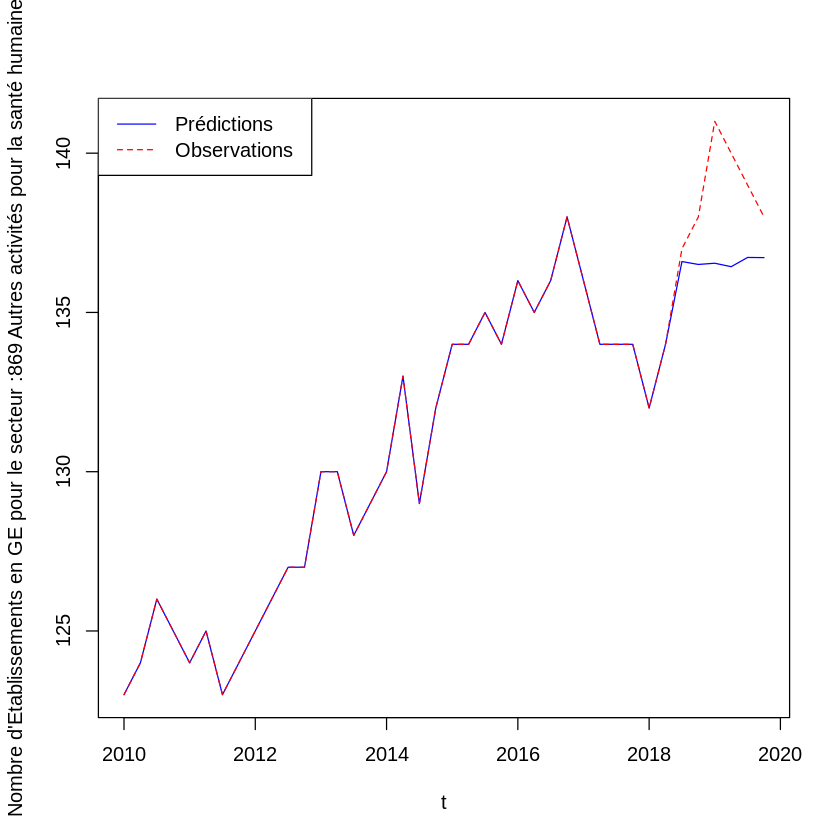

In [120]:
index_secteur <- 8
pred <-c(df.ts[1:(nrow(scaled_train)-prediction),index_secteur],LSTM_forecast[,,index_secteur])
pred <-ts(pred, start=c(2010,1),frequency=4)
obs <- df.ts[,index_secteur]

plot.ts(
    cbind(pred,obs),
    plot.type="single",
    lty=c(1,2),
    lwd=1,
    xlab="t",
    ylab=paste("Nombre d'Etablissements en GE pour le secteur :",lab.to.num$lab[index_secteur],sep=""),
    
    col=c("blue","red")
)
legend("topleft",

    legend=c("Prédictions","Observations"),
    col=c("blue","red"),
    lty=c(1,2),
    lwd=1
)

<hr>

### Save results

In [121]:
#-------------------------------
#Save all plots
for( index_secteur in 1:ncol(scaled_train)){

    png(file=paste("plots/LSTM_non_stable/",index_secteur,".png",sep=""))
    pred <-c(df.ts[1:(nrow(scaled_train)-prediction),index_secteur],LSTM_forecast[,,index_secteur])
    pred <-ts(pred, start=c(2010,1),frequency=4)
    obs <- df.ts[,index_secteur]

    plot.ts(
        cbind(pred,obs),
        plot.type="single",
        main=paste("Predictions LSTM non stable vs observations \n secteur : ",lab.to.num$lab[index_secteur],sep=""),
        col=c("blue","red"),
        lty=c(2,1),
        lwd=1,
        xlab="t",
        ylab=paste("Nombre d'Etablissements en GE pour le secteur :",lab.to.num$lab[index_secteur],sep=""),

    )
    legend("topleft",
        legend=c("Prédictions","Observations"),
        col=c("blue","red"),
        lty=c(2,1),
        lwd=1
)
    dev.off()
}

In [122]:
#----------------------
#Save model
save_model_tf(LSTM_model,"models/LSTM_non_stable")

<hr>

<div id="LSTMB">

## II.B LSTM model with stable TS

In [123]:
df.diff <-diff(df.ts)
df.train <-df.diff%>%as.data.frame
scaled_train <- scale(df.train)
scale_factor <-list("center"=attr(scaled_train,"scaled:center"),"sd"=attr(scaled_train,"scaled:scale"))
prediction <- 6
lag <- prediction

In [124]:
x_train_data <-t(sapply(
    1:(dim(scaled_train)[1]-lag-prediction +1),
    function(x){scaled_train[x:(x+lag-1),1]}
))

for(i in 2:ncol(scaled_train)){
    new <-t(sapply(
        1:(dim(scaled_train)[1]-lag-prediction +1),
        function(x){scaled_train[x:(x+lag-1),i]}
    ))
    x_train_data <-cbind(x_train_data,new)
    
}

x_train_arr <- array(
    data=as.numeric(unlist(x_train_data)),
    dim=c(
        nrow(x_train_data),
        ncol(x_train_data),
        1
        )

)
x_train_arr %>%dim

[1]  28 156   1

In [125]:
y_train_data <-  t(sapply(
    (1+lag):(dim(scaled_train)[1]-prediction +1),
    function(x){scaled_train[x:(x+prediction-1),1]}
))
y_train_arr <-array(
    data=as.numeric(unlist(y_train_data)),
    dim=c(
        nrow(y_train_data),
        prediction,
        1
    )
)
y_train_arr%>%dim

[1] 28  6  1

In [126]:
x_test <-df.train[(nrow(scaled_train)- prediction+1):nrow(scaled_train),]
for(i in 1:ncol(x_test)){
    x_test[,i] <-(x_test[,i] -scale_factor[["center"]][i])/scale_factor[["sd"]][i]
}
x_test_scaled <- x_test[,1]

In [127]:
x_test

,1,2,3,4,5,6,7,8,9,10,⋯,17,18,19,20,21,22,23,24,25,26
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
34,-0.339129297,0.27574168,-0.07250747,0.6807629,-1.3878366,-0.67485091,-0.5016331,1.5151134,1.33269168,-0.5840227,⋯,1.0589631,-0.9439893,-0.61245961,-0.5145595,-1.2109560,0.8919034,0.46265195,-1.297037,-1.12764156,1.2446400
35,0.116941137,0.05627381,-0.07250747,-0.9447322,0.5760831,-0.04820364,-0.2630515,0.3564973,-0.07203739,0.5548215,⋯,-0.9181435,1.8521309,0.75245037,0.0588068,0.6674019,-0.3653580,0.08674724,1.068196,0.38785591,0.7442177
36,-0.090363606,0.60494348,-0.07250747,0.1389312,-0.1309280,0.57844364,1.1684382,1.5151134,0.77080005,0.1752068,⋯,0.1363133,0.2210608,0.75245037,0.0588068,0.3990651,-0.3653580,-0.28915747,-0.792454,-1.09904726,-1.2574713
37,-0.007441709,-1.48000125,-0.07250747,0.1389312,0.2225776,1.20509091,0.2141117,-0.8021188,-0.35298320,-0.2044079,⋯,0.2241847,0.9200908,0.06999538,1.2055394,0.6674019,0.8919034,0.08674724,1.352024,0.73098741,0.2437955
38,-0.297668349,-0.05346012,1.81268664,0.6807629,0.1047424,-1.30149818,-0.7402147,-0.8021188,0.48985424,2.0732805,⋯,0.8832203,-1.1769993,0.06999538,-0.5145595,-0.9426192,-0.3653580,1.59036606,-1.896229,-0.46997285,0.2437955
39,0.075480188,-0.38266192,1.81268664,0.1389312,0.6939183,-0.04820364,-0.5016331,-0.8021188,-0.63392901,1.3140510,⋯,-0.9620792,-0.2449593,0.06999538,-0.5145595,0.9357388,0.8919034,-0.47710982,1.320487,0.04472441,1.7450622


In [128]:
x_pred_arr <- array(
    data=x_test,
    dim=c(1,lag,1)
)

In [129]:
x_train_arr %>%dim
y_train_arr %>%dim

[1]  28 156   1

[1] 28  6  1

In [130]:
x_bis <-sapply(
        1:ncol(scaled_train),
        function(x){scaled_train[1:(28-1+1),x]}
)

x_bis_first_array <-array(
    data=unlist(x_bis),
    dim=c(nrow(x_bis),1,ncol(x_bis))
)
tot_array <-array(NA, dim=c(
    nrow(x_bis),
    6,
    ncol(x_bis)
))
tot_array[,1,] <- x_bis_first_array


for (i in 2:6){
    new <-sapply(
        1:ncol(scaled_train),
        function(x){scaled_train[i:(i+28-1),x]}
    )
    new <- array(
        data=unlist(new),
        dim=c(nrow(x_bis),1,ncol(x_bis))
    )
    tot_array[,i,] <- new
}
x_train_arr_bis <- tot_array

In [131]:

y_train_data_bis <-  t(sapply(
    (1+lag):(dim(scaled_train)[1]-prediction +1),
    function(x){scaled_train[x:(x+prediction-1),1]}
))

tot_array <-array(NA, dim=c(
    nrow(y_train_data_bis),
    6,
    ncol(scaled_train)
))

tot_array[,,1] <- y_train_data_bis

for (i in 2:ncol(scaled_train)){
    new <-  t(sapply(
        (1+lag):(dim(scaled_train)[1]-prediction +1),
        function(x){scaled_train[x:(x+prediction-1),i]}
    ))

    new_array <- array(
        data=as.numeric(unlist(new)),
        dim=c(nrow(new),
        ncol(new),
        1)
    )
    tot_array[,,i] <- new_array

}

y_train_arr_bis <- tot_array

In [132]:
x_train_arr_bis%>%dim
y_train_arr_bis %>% dim

[1] 28  6 26

[1] 28  6 26

In [133]:
LSTM_model <- keras_model_sequential()

LSTM_model%>% layer_lstm(
    units=50,
    batch_input_shape=c(1,6,26),#BATCH size , timestep ,features
    return_sequences=T,
    stateful=T

)%>%
layer_dropout(rate=0.5)%>%layer_lstm(
    units =50,
    return_sequences=T,stateful=T
)%>% layer_dropout(rate=0.5)%>% time_distributed(keras::layer_dense(units=26))

In [134]:
LSTM_model %>% compile(loss='mae',optimizer='adam',metrics='accuracy')
summary(LSTM_model)

Model: "sequential_3"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 lstm_7 (LSTM)                      (1, 6, 50)                      15400       
 dropout_7 (Dropout)                (1, 6, 50)                      0           
 lstm_6 (LSTM)                      (1, 6, 50)                      20200       
 dropout_6 (Dropout)                (1, 6, 50)                      0           
 time_distributed_3 (TimeDistribute  (1, 6, 26)                     1326        
 d)                                                                             
Total params: 36,926
Trainable params: 36,926
Non-trainable params: 0
________________________________________________________________________________


In [135]:
LSTM_model %>% keras::fit(
    x=x_train_arr_bis,
    y=y_train_arr_bis,
    batch_size=1,
    epochs=20,# Number of times to iterate over the training data
    verbose=2,
    shuffle=FALSE,
    
)

In [136]:
x_test <-df.train[(nrow(scaled_train)- prediction+1):nrow(scaled_train),]
for(i in 1:ncol(x_test)){
    x_test[,i] <-(x_test[,i] -scale_factor[["center"]][i])/scale_factor[["sd"]][i]
}
x_test_scaled <- x_test
x_test_scaled

,1,2,3,4,5,6,7,8,9,10,⋯,17,18,19,20,21,22,23,24,25,26
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
34,-0.339129297,0.27574168,-0.07250747,0.6807629,-1.3878366,-0.67485091,-0.5016331,1.5151134,1.33269168,-0.5840227,⋯,1.0589631,-0.9439893,-0.61245961,-0.5145595,-1.2109560,0.8919034,0.46265195,-1.297037,-1.12764156,1.2446400
35,0.116941137,0.05627381,-0.07250747,-0.9447322,0.5760831,-0.04820364,-0.2630515,0.3564973,-0.07203739,0.5548215,⋯,-0.9181435,1.8521309,0.75245037,0.0588068,0.6674019,-0.3653580,0.08674724,1.068196,0.38785591,0.7442177
36,-0.090363606,0.60494348,-0.07250747,0.1389312,-0.1309280,0.57844364,1.1684382,1.5151134,0.77080005,0.1752068,⋯,0.1363133,0.2210608,0.75245037,0.0588068,0.3990651,-0.3653580,-0.28915747,-0.792454,-1.09904726,-1.2574713
37,-0.007441709,-1.48000125,-0.07250747,0.1389312,0.2225776,1.20509091,0.2141117,-0.8021188,-0.35298320,-0.2044079,⋯,0.2241847,0.9200908,0.06999538,1.2055394,0.6674019,0.8919034,0.08674724,1.352024,0.73098741,0.2437955
38,-0.297668349,-0.05346012,1.81268664,0.6807629,0.1047424,-1.30149818,-0.7402147,-0.8021188,0.48985424,2.0732805,⋯,0.8832203,-1.1769993,0.06999538,-0.5145595,-0.9426192,-0.3653580,1.59036606,-1.896229,-0.46997285,0.2437955
39,0.075480188,-0.38266192,1.81268664,0.1389312,0.6939183,-0.04820364,-0.5016331,-0.8021188,-0.63392901,1.3140510,⋯,-0.9620792,-0.2449593,0.06999538,-0.5145595,0.9357388,0.8919034,-0.47710982,1.320487,0.04472441,1.7450622


In [137]:
x_test_array <- array(
    data = as.numeric(unlist(x_test_scaled)),
    dim=c(1,6,26)
)

In [138]:
LSTM_forecast <- LSTM_model %>% predict(x_test_array,batch_size=1)
LSTM_forecast %>%dim

[1]  1  6 26

In [140]:
#----------------------------------
# Remembering we did 2 operations before inputing datat in our model : 
# 1.Differenciation
# 2. Scaling

#-------------
# 1.unscale Predictions
for (i in 1: dim(LSTM_forecast)[3]){
    LSTM_forecast[,,i] <- LSTM_forecast[,,i] * scale_factor[["sd"]][i] +scale_factor[["center"]][i]
}


In [141]:
LSTM_forecast[,,1] # There are still differenciate

[1] -9.075114 -4.536398 -6.001532 -4.308303 -9.030695 -5.828090

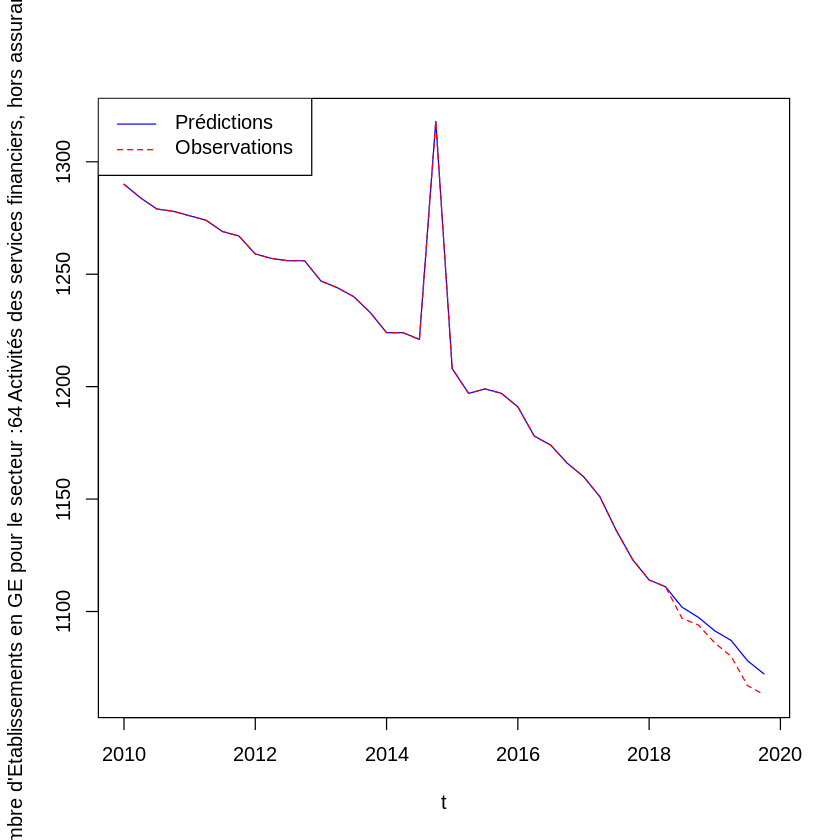

In [142]:
index_secteur <- 1
pred <- c(df.diff[1:(nrow(scaled_train)-prediction),index_secteur],LSTM_forecast[,,index_secteur])
pred <-ts(pred, start=c(2010,2),frequency=4)
obs <- df.diff[,index_secteur]

#-----------------
# Inverse differenciation
starting_point <- df.ts[1,index_secteur]
obs <-diffinv(obs,xi=starting_point)
pred <-diffinv(pred,xi=starting_point)
plot.ts(
    cbind(pred,obs),
    plot.type="single",
    lty=c(1,2),
    lwd=1,
    xlab="t",
    ylab=paste("Nombre d'Etablissements en GE pour le secteur :",lab.to.num$lab[index_secteur],sep=""),
    
    col=c("blue","red")
)
legend("topleft",

    legend=c("Prédictions","Observations"),
    col=c("blue","red"),
    lty=c(1,2),
    lwd=1
)

In [143]:
#-------------------------------
#Save all plots
for( index_secteur in 1:ncol(scaled_train)){

    png(file=paste("plots/LSTM_stable/",index_secteur,".png",sep=""))
    pred <- c(df.diff[1:(nrow(scaled_train)-prediction),index_secteur],LSTM_forecast[,,index_secteur])
    pred <-ts(pred, start=c(2010,2),frequency=4)
    obs <- df.diff[,index_secteur]
    
    #-----------------
    # Inverse differenciation
    starting_point <- df.ts[1,index_secteur]
    obs <-diffinv(obs,xi=starting_point)
    pred <-diffinv(pred,xi=starting_point)

    plot.ts(
        cbind(pred,obs),
        plot.type="single",
        main=paste("Predictions LSTM stable vs observations \n secteur : ",lab.to.num$lab[index_secteur],sep=""),
        col=c("blue","red"),
        lty=c(2,1),
        lwd=1,
        xlab="t",
        ylab=paste("Nombre d'Etablissements en GE pour le secteur :",lab.to.num$lab[index_secteur],sep=""),

    )
    legend("topleft",
        legend=c("Prédictions","Observations"),
        col=c("blue","red"),
        lty=c(2,1),
        lwd=1
)
    dev.off()
}

In [144]:
#----------------------
#Save model
save_model_tf(LSTM_model,"models/LSTM_stable")

### Calculate RMSE *Residual Mean Square Error*

In [201]:
(nrow(scaled_train)-prediction+1):nrow(scaled_train) 
1:(nrow(scaled_train)-prediction)


[1] 34 35 36 37 38 39

[1]  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
[26] 26 27 28 29 30 31 32 33

[1] 1114 1100 1097 1089 1083 1070 1066

[1] 1114.000 1104.925 1100.388 1094.387 1090.079 1081.048 1075.220

In [202]:
RMSE <- c()
for (var in 1:dim(LSTM_forecast)[3]){
    obs <-df.diff[(nrow(scaled_train)-prediction+1):nrow(scaled_train),var]
    pred <- LSTM_forecast[,,var]
    starting_point <- df.ts[nrow(scaled_train)-prediction,var]
    obs <-diffinv(obs,xi=starting_point)
    pred <-diffinv(pred,xi=starting_point)
    RMSE <-c(RMSE,sqrt(mean((obs-pred)^2)))
}

In [203]:
RMSE_stable_LSTM <-RMSE %>% as.data.frame()
colnames(RMSE_stable_LSTM) <-"rmse"
RMSE_stable_LSTM


rmse
<dbl>
6.78155325
5.47183157
1.90814840
0.83335382
31.80338227
0.85532909
1.95620285
3.59230963
5.06823544


In [204]:
summary(RMSE_stable_LSTM$rmse)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
 0.05988  1.92016  3.70089  9.21708  9.63065 48.32035 

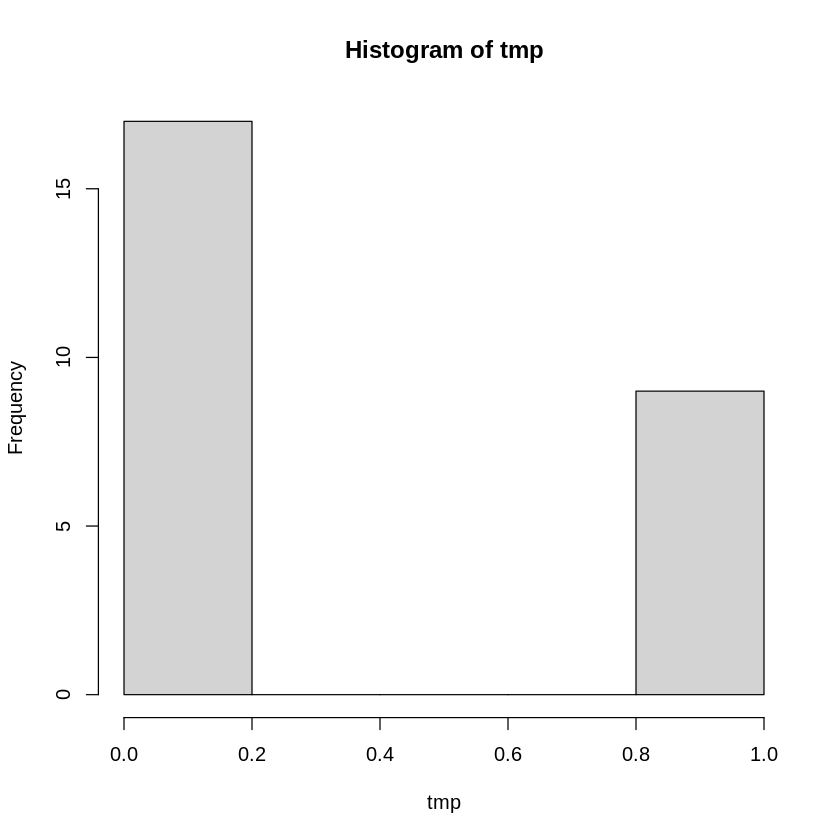

In [205]:
RMSE_stable_LSTM$group <- RMSE_stable_LSTM$rmse >6.92
tmp <-apply(RMSE_stable_LSTM,1,FUN=function(x){if(x[2]){return(1)}else{return(0) }})

hist(tmp)


### Calculate MAE *Mean Absolute Error*

In [186]:
var <- 1
obs <-df.diff[(nrow(scaled_train)-prediction+1):nrow(scaled_train),var]
pred <- LSTM_forecast[,,var]
abs(obs-pred)

[1] 4.924886 1.536398 1.998468 1.691697 3.969305 1.828090

In [214]:
MAE <- c()
for (var in 1:dim(LSTM_forecast)[3]){
    obs <-df.diff[(nrow(scaled_train)-prediction+1):nrow(scaled_train),var]
    pred <- LSTM_forecast[,,var]
    starting_point <- df.ts[nrow(scaled_train)-prediction,var]
    obs <-diffinv(obs,xi=starting_point)
    pred <-diffinv(pred,xi=starting_point)
    
    MAE <-c(MAE,mean(abs(obs-pred)))
    
}
MAE <- MAE %>%as.data.frame()
colnames(MAE) <- "MAE"
MAE

MAE
<dbl>
5.86382921
4.66540830
1.03364741
0.75781189
28.83181754
0.71344470
1.64135510
3.02188631
4.54053897


In [207]:
summary(MAE)

      mae        
 Min.   : 0.050  
 1st Qu.: 1.169  
 Median : 3.158  
 Mean   : 7.650  
 3rd Qu.: 7.133  
 Max.   :42.630  

### Calculate MAPE *Mean Absolute  Percentage Error*

**They have the advantage to be unit free.**

Measures based on percentage errors have the disadvantage of being infinite or undefined if yt=0 for any t in the period of interest, and having extreme values if any yt is close to zero. Another problem with percentage errors that is often overlooked is that they assume the unit of measurement has a meaningful zero.2 For example, a percentage error makes no sense when measuring the accuracy of temperature forecasts on either the Fahrenheit or Celsius scales, because temperature has an arbitrary zero point.

**Ceci ne possera pas de probleme si l'on unscale + inv differenciate**

In [215]:
MAPE <- c()
for (var in 1:dim(LSTM_forecast)[3]){
    obs <-df.diff[(nrow(scaled_train)-prediction+1):nrow(scaled_train),var]
    pred <- LSTM_forecast[,,var]
    starting_point <- df.ts[nrow(scaled_train)-prediction,var]
    obs <-diffinv(obs,xi=starting_point)
    pred <-diffinv(pred,xi=starting_point)
    
    MAPE <-c(MAPE,mean(abs((obs-pred)*100/obs)))
    
}
MAPE <- MAPE %>%as.data.frame()
colnames(MAPE) <- "MAPE"
MAPE

MAPE
<dbl>
0.5431873
1.2219342
1.4337104
0.5234455
2.6981469
0.7198186
0.9232656
2.2011203
0.4620767


In [210]:
summary(MAPE)

      mape       
 Min.   :0.3972  
 1st Qu.:0.7820  
 Median :1.8736  
 Mean   :2.1845  
 3rd Qu.:2.6584  
 Max.   :6.0756  

They also have the disadvantage that they put a heavier penalty on negative errors than on positive errors. This observation led to the use of the so-called “symmetric” MAPE (sMAPE) proposed by Armstrong (1978, p. 348), which was used in the M3 forecasting competition. 
It is defined by

$sMAPE=mean(200|obs−pred|/(obs+pred))$

https://otexts.com/fpp2/accuracy.html

In [223]:
sMAPE <- c()
for (var in 1:dim(LSTM_forecast)[3]){
    obs <-df.diff[(nrow(scaled_train)-prediction+1):nrow(scaled_train),var]
    pred <- LSTM_forecast[,,var]
    starting_point <- df.ts[nrow(scaled_train)-prediction,var]
    obs <-diffinv(obs,xi=starting_point)
    pred <-diffinv(pred,xi=starting_point)
    
    sMAPE <-c(sMAPE,mean(200*abs(obs-pred)/(obs+pred)))
    
}
sMAPE <- sMAPE %>%as.data.frame()
colnames(sMAPE) <- "sMAPE"
sMAPE

sMAPE
<dbl>
0.5412083
1.2206236
1.4692833
0.5237809
2.6545764
0.7184889
0.9226217
2.2357391
0.4634092


In [224]:
predict_accuracy <- cbind("secteurs"=lab.to.num$lab,RMSE,MAE,MAPE,sMAPE)

predict_accuracy

secteurs,RMSE,MAE,MAPE,sMAPE
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
"64 Activités des services financiers, hors assurance et",6.78155325,5.86382921,0.5431873,0.5412083
65-66 Assurance ; Activités auxiliaires de services fin,5.47183157,4.66540830,1.2219342,1.2206236
852 Enseignement primaire,1.90814840,1.03364741,1.4337104,1.4692833
853 Enseignement secondaire,0.83335382,0.75781189,0.5234455,0.5237809
85x Enseignement / Autre,31.80338227,28.83181754,2.6981469,2.6545764
861 Activités hospitalières,0.85532909,0.71344470,0.7198186,0.7184889
862 Activité des médecins et des dentistes,1.95620285,1.64135510,0.9232656,0.9226217
869 Autres activités pour la santé humaine,3.59230963,3.02188631,2.2011203,2.2357391
87 Hébergement médico-social et social,5.06823544,4.54053897,0.4620767,0.4634092


# With validation DATA
*Rmrq : Ce n'est pas un nouveau modèle etant donnée que l'on entraine notre modele sur exactement les meem données. Le seul interet de cette partie est ainsi de pouvoir obtenir un graphe concernant la précision des prévisions fournies*

In [ ]:
y_test <-df.train[(nrow(scaled_train)- prediction+1):nrow(scaled_train),]
for(i in 1:ncol(y_test)){
    y_test[,i] <-(y_test[,i] -scale_factor[["center"]][i])/scale_factor[["sd"]][i]
}
y_test_scaled <- y_test
y_test_scaled
cat("time interval taken into Y_test:", (nrow(scaled_train)- prediction+1):nrow(scaled_train))

,1,2,3,4,5,6,7,8,9,10,⋯,17,18,19,20,21,22,23,24,25,26
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
34,-0.339129297,0.27574168,-0.07250747,0.6807629,-1.3878366,-0.67485091,-0.5016331,1.5151134,1.33269168,-0.5840227,⋯,1.0589631,-0.9439893,-0.61245961,-0.5145595,-1.2109560,0.8919034,0.46265195,-1.297037,-1.12764156,1.2446400
35,0.116941137,0.05627381,-0.07250747,-0.9447322,0.5760831,-0.04820364,-0.2630515,0.3564973,-0.07203739,0.5548215,⋯,-0.9181435,1.8521309,0.75245037,0.0588068,0.6674019,-0.3653580,0.08674724,1.068196,0.38785591,0.7442177
36,-0.090363606,0.60494348,-0.07250747,0.1389312,-0.1309280,0.57844364,1.1684382,1.5151134,0.77080005,0.1752068,⋯,0.1363133,0.2210608,0.75245037,0.0588068,0.3990651,-0.3653580,-0.28915747,-0.792454,-1.09904726,-1.2574713
37,-0.007441709,-1.48000125,-0.07250747,0.1389312,0.2225776,1.20509091,0.2141117,-0.8021188,-0.35298320,-0.2044079,⋯,0.2241847,0.9200908,0.06999538,1.2055394,0.6674019,0.8919034,0.08674724,1.352024,0.73098741,0.2437955
38,-0.297668349,-0.05346012,1.81268664,0.6807629,0.1047424,-1.30149818,-0.7402147,-0.8021188,0.48985424,2.0732805,⋯,0.8832203,-1.1769993,0.06999538,-0.5145595,-0.9426192,-0.3653580,1.59036606,-1.896229,-0.46997285,0.2437955
39,0.075480188,-0.38266192,1.81268664,0.1389312,0.6939183,-0.04820364,-0.5016331,-0.8021188,-0.63392901,1.3140510,⋯,-0.9620792,-0.2449593,0.06999538,-0.5145595,0.9357388,0.8919034,-0.47710982,1.320487,0.04472441,1.7450622


time interval taken into Y_test: 34 35 36 37 38 39

In [ ]:
(nrow(scaled_train)- prediction-prediction+1):(nrow(scaled_train)-prediction)
x_test <-df.train[(nrow(scaled_train)- prediction-prediction+1):(nrow(scaled_train)-prediction),]
for(i in 1:ncol(x_test)){
    x_test[,i] <-(x_test[,i] -scale_factor[["center"]][i])/scale_factor[["sd"]][i]
}
x_test_scaled <- x_test
x_test_scaled
cat("time interval taken into Y_test:",(nrow(scaled_train)- prediction-prediction+1):(nrow(scaled_train)-prediction))

[1] 28 29 30 31 32 33

,1,2,3,4,5,6,7,8,9,10,⋯,17,18,19,20,21,22,23,24,25,26
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
28,-0.007441709,-0.16319405,0.87008959,-0.4029005,-1.50567174,0.57844364,0.92985654,-1.3814269,1.05174586,0.5548215,⋯,0.004506226,-1.4100094,0.06999538,0.0588068,1.4724125,-0.78444517,-1.79277629,-0.9185998,-0.8988872,-0.7570491
29,-0.131824555,-0.05346012,-0.07250747,-0.4029005,0.22257756,-0.67485091,2.59992783,-1.3814269,-0.35298320,-0.2044079,⋯,-0.083365181,-0.4779693,-0.61245961,0.0588068,0.9357388,1.31099056,0.65060430,1.0051228,1.2456847,0.2437955
30,-0.380590246,-0.16319405,-0.07250747,0.1389312,-1.19144460,-1.30149818,-0.74021475,-0.2228108,0.77080005,0.5548215,⋯,1.058963107,-0.9439893,0.06999538,0.0588068,-2.2843034,0.05372912,-1.98072864,-1.4862556,-0.7273215,1.7450622
31,-0.297668349,-0.05346012,0.87008959,0.1389312,0.65463989,-0.04820364,-0.50163313,-0.2228108,-0.07203739,-0.2044079,⋯,-1.006014951,0.6870808,-0.61245961,0.0588068,-0.4059455,-2.04170661,-0.66506217,1.6358515,-1.0990473,-0.2566268
32,-0.131824555,-0.05346012,-1.01510452,0.6807629,-0.40587673,1.83173818,-0.02446991,-1.3814269,1.33269168,-0.9636374,⋯,0.004506226,0.2210608,0.75245037,1.7789056,-2.0159666,0.89190341,-2.35663335,-1.2339641,-0.8702929,-1.7578936
33,0.116941137,-0.16319405,-0.07250747,0.6807629,-0.05237119,-1.30149818,-0.50163313,0.9358053,-0.91487483,0.1752068,⋯,0.136313336,-1.1769993,-1.97736959,0.0588068,0.9357388,-0.36535803,0.08674724,0.6582220,-0.3270014,0.7442177


time interval taken into Y_test: 28 29 30 31 32 33

In [ ]:
x_test_array <- array(
    data = as.numeric(unlist(x_test_scaled)),
    dim=c(1,6,26)
)

In [ ]:
y_test_array <- array(
    data = as.numeric(unlist(y_test_scaled)),
    dim=c(1,6,26)
)

In [ ]:
history <-LSTM_model %>% keras::fit(
    x=x_train_arr_bis,
    y=y_train_arr_bis,
    batch_size=1,
    epochs=20,# Number of times to iterate over the training data
    verbose=2,
    shuffle=FALSE,
    validation_data =list(x_test_array,y_test_array)
    
)

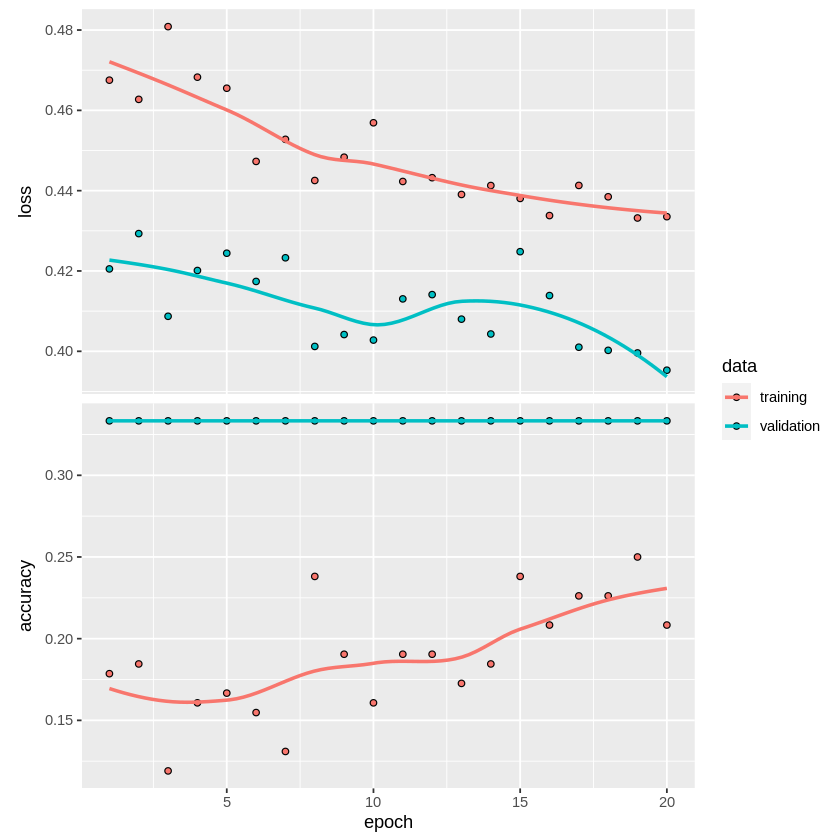

In [ ]:
plot(history)